# Preparing the dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/facebook_data.csv')

In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'page_total_likes', 'type', 'category', 'post_month',
       'post_weekday', 'post_hour', 'paid', 'total_interactions',
       'total_reach'],
      dtype='object')


In [ ]:
df.drop(df.columns[0], inplace=True, axis=1)
# Since on looking at the data, the first column corresponds to the post's index in the data

In [ ]:
print(df.columns)

Index(['page_total_likes', 'type', 'category', 'post_month', 'post_weekday',
       'post_hour', 'paid', 'total_interactions', 'total_reach'],
      dtype='object')


In [ ]:
X = df.iloc[:, :7]
# get the features that we want to use to predict total_reach and total_interactions

In [ ]:
print(X.columns)

Index(['page_total_likes', 'type', 'category', 'post_month', 'post_weekday',
       'post_hour', 'paid'],
      dtype='object')


# Problem 1 (Exploratory Data Analysis)

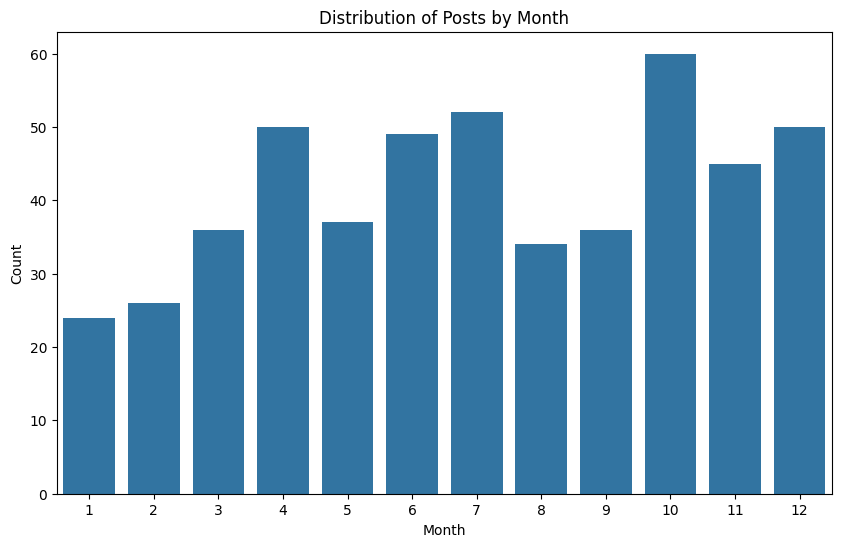

In [ ]:
# Histogram for Post Month
plt.figure(figsize=(10, 6))
sns.countplot(x='post_month', data=df)
plt.title('Distribution of Posts by Month˙
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

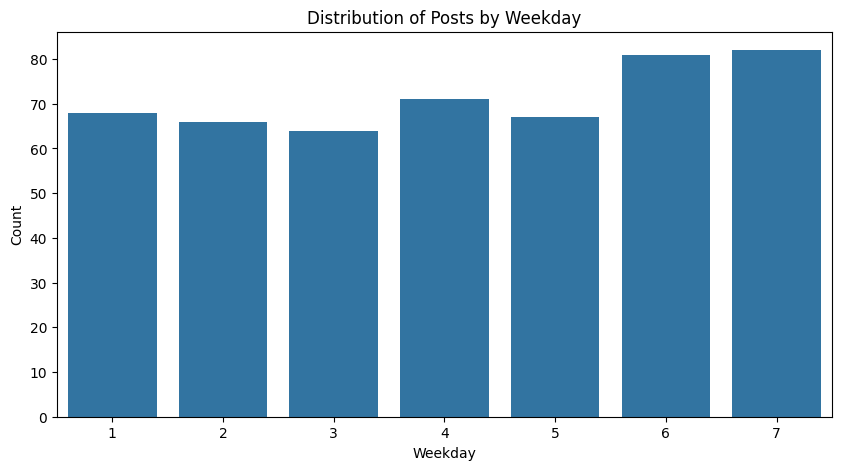

In [ ]:
# Histogram for Post Weekday
plt.figure(figsize=(10, 5))
sns.countplot(x='post_weekday', data=df)
plt.title('Distribution of Posts by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.show()

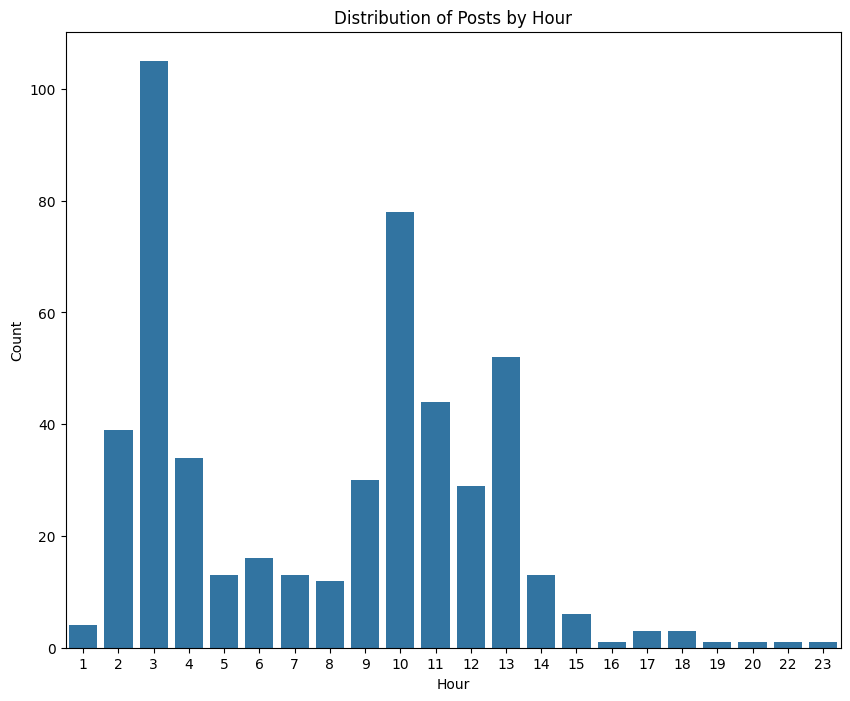

In [ ]:
# Histogram for Post Hour
plt.figure(figsize=(10, 8))
sns.countplot(x='post_hour', data=df)
plt.title('Distribution of Posts by Hour')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

In [ ]:
# Checking since I don't see anything on the histoplot with hour == 0 even though that is part of the 24-hour time
print((df['post_hour'] == 0).sum())
# Checking min and max of post_hour
print(df['post_hour'].min())
print(df['post_hour'].max())

0
1
23


> None of the times data is approximately normally distributed and this is likely due to factors within the company that cause some time spans to have more posts than others.

> For the hours, this company likely favors some times of posting much more than others like almost any reasonable marketing strategy would do. The count could peak as early as hour 3 due to it being daytime in another timezone or to make sure everyone sees their product before heading off to work. It also sharply increases from hour 9 to 13 (10:00 A.M. to 2:00 P.M.) since that might be the peak time to shop especially on weekends in their home timezone. It could be too late for people to shop at later times (hence very few posts at hours 16-23), being either late evening or slightly past midnight depending on time zone

> For weekdays, it seems like the posts by weekday are around the same for Sunday through Thursday before increasing on Friday and Saturday. This is likely because people are more willing to go shopping on Friday and Saturday (such as due to not having work or due to getting their paychecks) and being busy from Sunday through Thursday

> For months, the company currently has fewer posts in some months and more in other months; this could be due to financial factors (such as fiscal quarters) or even the demand of their products varying with seasons or weather (ex: winter makes skin drier on average)

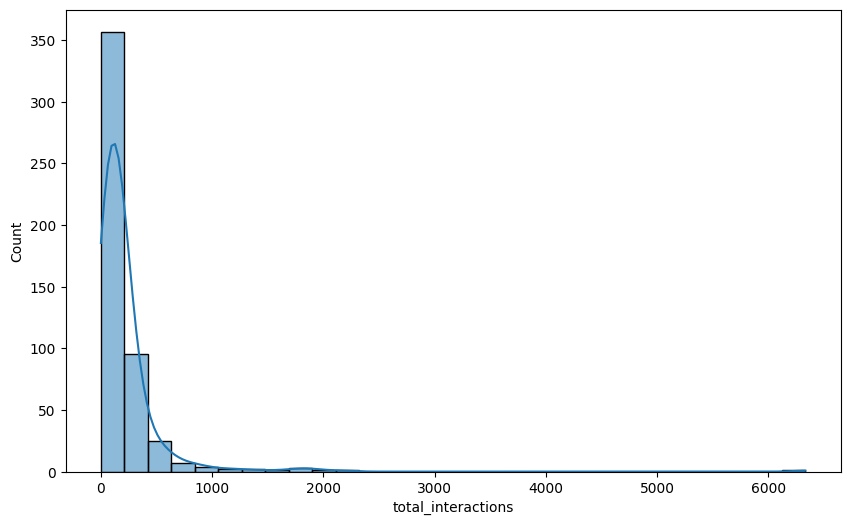

In [ ]:
# Dense histogram plot for the total posts' interactions
plt.figure(figsize=(10, 6))
sns.histplot(df['total_interactions'], bins=30, kde=True)
plt.show()

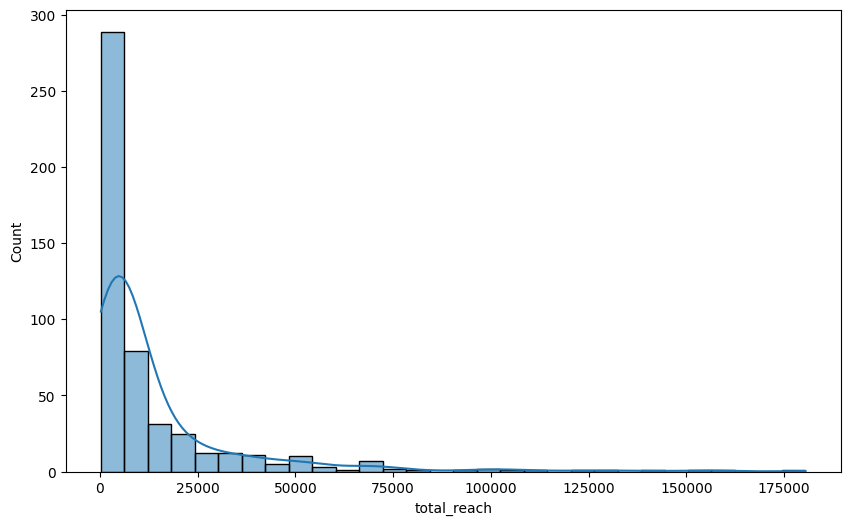

In [ ]:
# Dense histogram plot for the total posts' reach
plt.figure(figsize=(10, 6))
sns.histplot(df['total_reach'], bins=30, kde=True)
plt.show()

> Here, the distributions would seem to be normal but mostly in the decreasing direction (only the last bit of the left half and mostly the right half of a bell curve). This is probably because the total_reach and total_interactions values cannot be negative

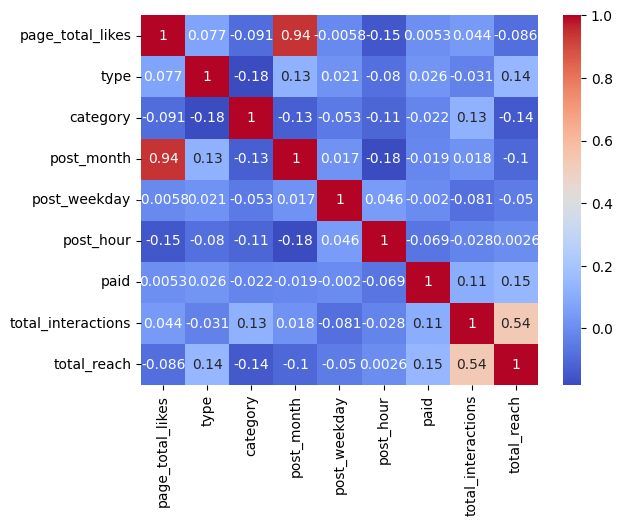

In [ ]:
pairwise_correlation_matrix = df.corr(method='pearson', min_periods=1)
sns.heatmap(pairwise_correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

> I see that the page_total_likes is strongly correlated with the post_month (in the positive direction). This is probably because the likes only increased with increasing post_month values since this data is only from one year (being 2014). Aside from that, total_interactions and total_reach seem to be somewhat correlated (in the positive direction, and it makes sense that one would more likely increase than decrease if the other increases) but this correlation is not strong enough for me to make any conclusions about the relationships between these total_interactions and total_reach just yet

> The rest of these pairs of features don't seem to have any significant correlations (for both the positive and negative correlation coefficients)

# Question 2 (linear and multilinear regression with 'total_interactions')

In [ ]:
y = df['total_interactions']
# remember, we have X as the features 'page_total_likes' through 'paid'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
def loss_function(y, y_pred):
  return torch.mean((y-y_pred)**2)

### Question 2 data preprocessing

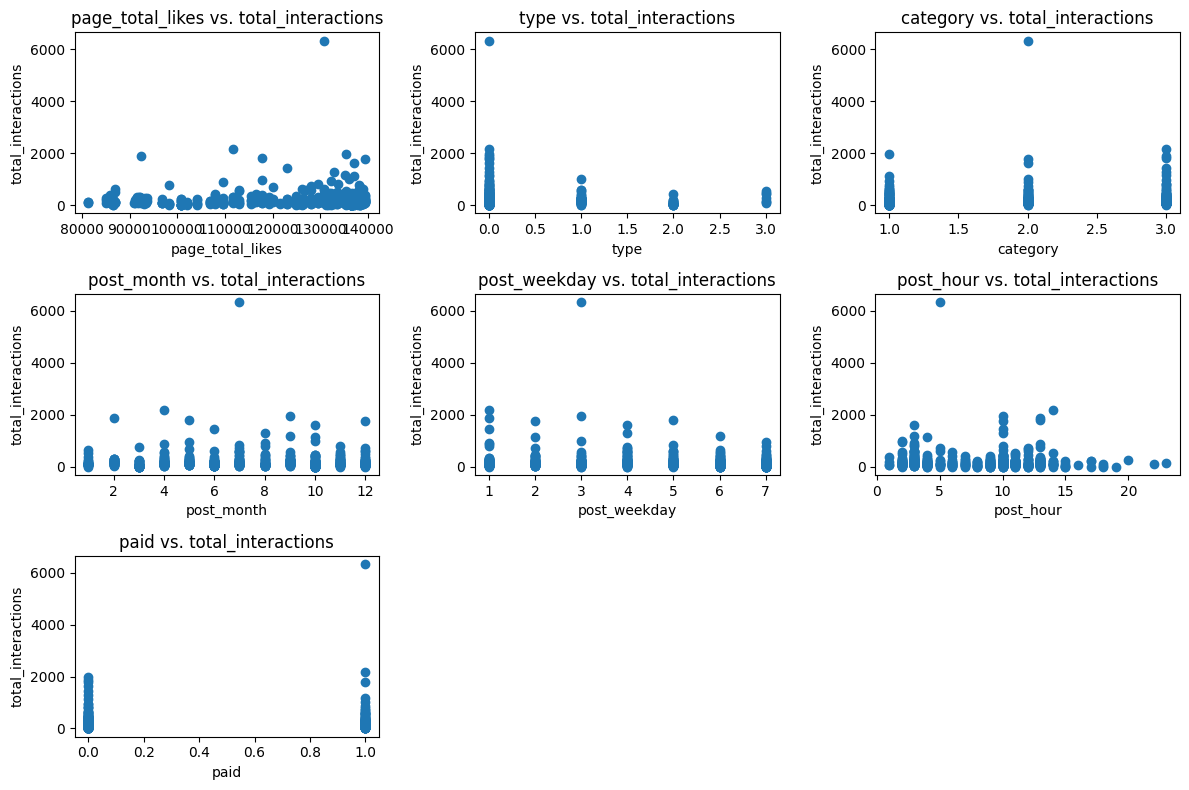

In [ ]:
# Plot each feature of X versus 'total_interactions'
plt.figure(figsize=(12, 8)) # Adjusted figure size for better visualization
# Increased the number of rows to 3 to accommodate all 7 features
for i, feature in enumerate(X.columns):
    plt.subplot(3, 3, i + 1)  # Changed to 3 rows, 3 columns
    plt.scatter(X[feature], y)
    plt.title(f'{feature} vs. total_interactions')  # Added title for each subplot
    plt.xlabel(feature)
    plt.ylabel('total_interactions')

plt.tight_layout()  # Adjusts subplot params for a tight layout
plt.show()

> From here, I see that there are several high outliers, and thus removing them would likely be helpful. I would also like to remove high outliers from the edited dataset, and so on until no more outliers are removed

> I think this is helpful because it is likely a company like this has some outliers in their total_interactions due to factors affecting specific posts, such as cross-promotions with other companies or other kinds of promotions not accounted for in the dataset

> Now I want to see the effects of each post metric in relation with each other and with page_total_likes

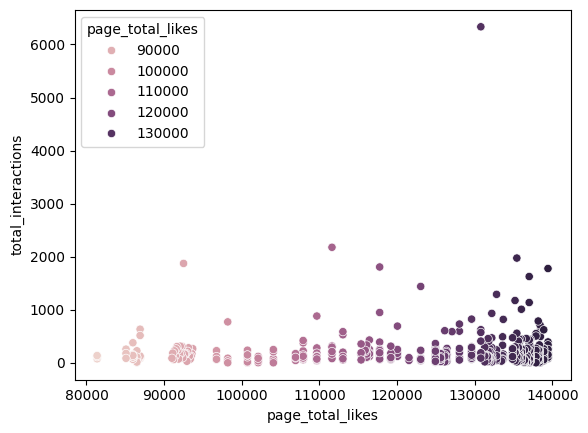

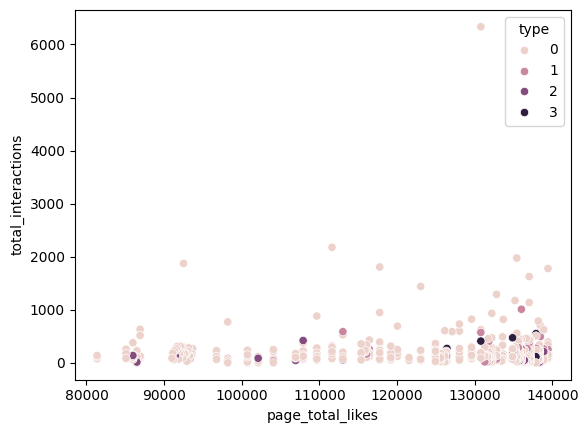

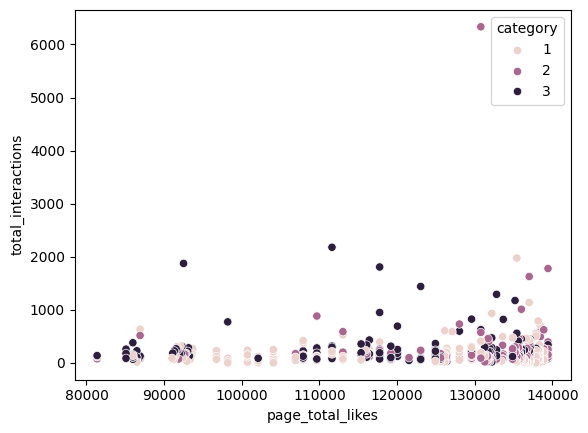

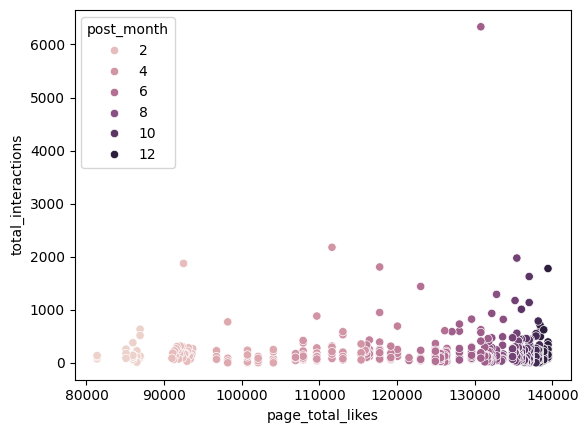

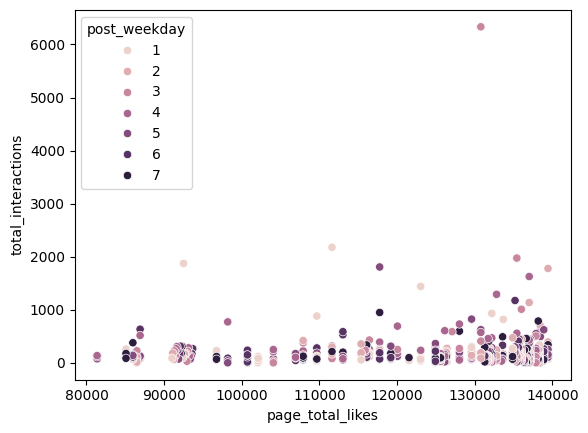

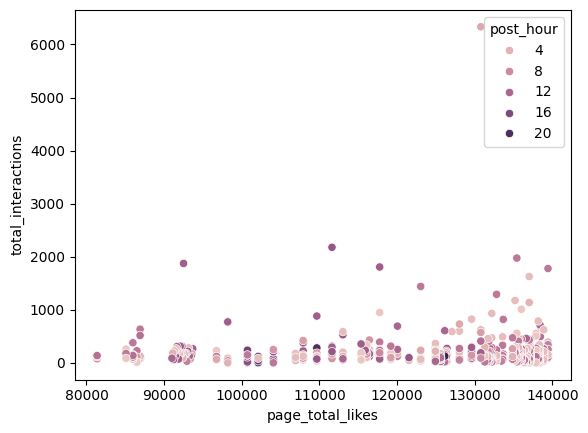

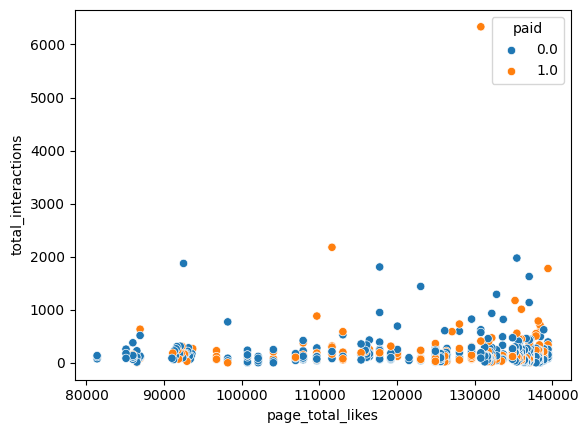

In [ ]:
for feature in X.columns:
  sns.scatterplot(x='page_total_likes', y='total_interactions', data=df, hue=feature)
  plt.show()

In [ ]:
# Create copies of the old df and X and y
df_old = df.copy(deep=True)
X_old = X.copy(deep=True)
y_old = y.copy(deep=True)

In [ ]:
# Remove outliers more than 3 standard deviations from the mean
y_temp  = np.array([0])
while (not np.array_equal(y_temp, y.values)):
  y_temp = y.copy()
  mean_total_interactions = y.mean()
  std_total_interactions = y.std()
  indices = (y >= mean_total_interactions - 3 * std_total_interactions) & (y <= mean_total_interactions + 3 * std_total_interactions)
  y = y[indices]
  X = X[indices]
  df = df[indices]

In [ ]:
# Just checking the effect on X and y to make sure there isn't an issue with it
print(f"X old mean: {X_old.mean()}\n")
print(f"X current mean: {X.mean()}\n")
print(f"X old std: {X_old.std()}\n")
print(f"X current std: {X.std()}\n")

X old mean: page_total_likes    123277.991984
type                     0.220441
category                 1.879760
post_month               7.050100
post_weekday             4.150301
post_hour                7.847695
paid                     0.278557
dtype: float64

X current mean: page_total_likes    122878.233333
type                     0.217778
category                 1.864444
post_month               6.982222
post_weekday             4.180000
post_hour                7.935556
paid                     0.266667
dtype: float64

X old std: page_total_likes    16180.746980
type                    0.587267
category                0.853513
post_month              3.300160
post_weekday            2.032728
post_hour               4.369579
paid                    0.448739
dtype: float64

X current std: page_total_likes    16373.296347
type                    0.575401
category                0.853045
post_month              3.323621
post_weekday            2.054069
post_hour               4.

In [ ]:
print(f"y old mean: {y_old.mean()}\n")
print(f"y current mean: {y.mean()}\n")
print(f"y old std: {y_old.std()}\n")
print(f"y current std: {y.std()}\n")

y old mean: 212.3066132264529

y current mean: 133.93555555555557

y old std: 380.5917662621443

y current std: 92.38299204133986



In [ ]:
print(f"Old df shape: {df_old.shape}")
print(f"New df shape: {df.shape}")
# Wow! We removed 49 entries in our loop!

Old df shape: (499, 9)
New df shape: (450, 9)


> We removed 49 outlier entries and significantly decreased the mean, but better yet, got the std all the way down from 380.592 to 92.383

In [ ]:
# Print the mean and std for different feature values in the old df
for feature in X_old.columns:
  if feature != 'page_total_likes':
    # Create a temporary DataFrame with selected columns
    temp_df = df_old[[feature, 'total_interactions']]  # Use the original dataframe 'df' instead of 'X_old'
    # Group by the current feature and calculate mean and std of 'total_interactions'
    result = temp_df.groupby(feature)['total_interactions'].agg(['mean', 'std'])

    # Print the results for the current feature
    print(f"Feature: {feature}")
    print(result)
    print("\n")

Feature: type
            mean         std
type                        
0     216.809412  406.159671
1     217.044444  178.479940
2      89.045455   95.720564
3     295.857143  183.992236


Feature: category
                mean         std
category                        
1         148.488372  207.965554
2         265.286822  593.044781
3         256.735484  325.520085


Feature: post_month
                  mean         std
post_month                        
1           162.333333  149.181147
2           242.038462  342.605368
3            97.055556  137.567634
4           217.520000  324.080000
5           256.297297  315.186441
6           157.714286  214.798258
7           328.500000  869.632861
8           225.382353  284.099749
9           278.500000  354.289430
10          182.900000  288.647912
11          185.755556  156.324714
12          201.340000  276.159419


Feature: post_weekday
                    mean         std
post_weekday                        
1             237

In [ ]:
# Now compare to the statistics in the newer df, X, and y
for feature in X.columns:
  if feature != 'page_total_likes':
    # Create a temporary DataFrame with selected columns
    temp_df = df[[feature, 'total_interactions']]  # Use the original dataframe 'df' instead of 'X_old
    # Group by the current feature and calculate mean and std of 'total_interactions'
    result = temp_df.groupby(feature)['total_interactions'].agg(['mean', 'std'])

    # Print the results for the current feature
    print(f"Feature: {feature}")
    print(result)
    print("\n")

Feature: type
            mean         std
type                        
0     132.057441   90.903532
1     173.292683   94.390477
2      73.285714   62.315442
3     209.800000  132.735451


Feature: category
                mean        std
category                       
1         102.449495  89.479062
2         152.747826  85.033207
3         163.649635  88.804030


Feature: post_month
                  mean         std
post_month                        
1           124.909091   80.223443
2           176.800000   83.671979
3            77.800000   75.768921
4           139.622222   85.229980
5           169.969697   85.068900
6           120.936170   82.000372
7           144.545455   84.549271
8           126.344828   97.598037
9           182.781250   99.742163
10          102.150943  108.910407
11          141.375000   84.714509
12          130.266667   88.469923


Feature: post_weekday
                    mean         std
post_weekday                        
1             129.0161

> We can see by the sharp differences in means and stds for some categories that outliers were really skewing the data. As such, I will use df instead of df_old going forward

> Also, a NaN STD for post_hour = 16 and post_hour = 19 through 23 (along with integer means) indicates to me that those categories likely only have a few samples. Specifically, in my opinion, there are too few samples in these categories to be representative of these categories' distributions. I will print out the number of samples in each of these categories to be sure

> I will also do the same for all category values


In [ ]:
# Print the counts of feature values in each category (if it's too few, I will remove samples in those categories)
for feature in X.columns:
  if feature != 'page_total_likes':
    print(f"Feature: {feature}")
    print(X[feature].value_counts())
    print("\n")

Feature: type
type
0    383
1     41
2     21
3      5
Name: count, dtype: int64


Feature: category
category
1    198
3    137
2    115
Name: count, dtype: int64


Feature: post_month
post_month
10    53
6     47
4     45
12    45
7     44
11    40
3     35
5     33
9     32
8     29
2     25
1     22
Name: count, dtype: int64


Feature: post_weekday
post_weekday
7    77
6    76
1    62
5    60
2    59
3    58
4    58
Name: count, dtype: int64


Feature: post_hour
post_hour
3     90
10    68
13    48
11    42
2     35
4     32
9     30
12    25
6     14
8     12
7     12
14    11
5     10
15     6
1      4
18     3
17     3
23     1
20     1
22     1
19     1
16     1
Name: count, dtype: int64


Feature: paid
paid
0.0    330
1.0    120
Name: count, dtype: int64




> From here, I will exclude post_hour==1 and 15 through 23, and type==3

In [ ]:
hours_to_exclude = [1, 15, 16, 17, 18, 19, 20, 22, 23]
types_to_exclude = [3]

for hour in hours_to_exclude:
  # Get the number of samples with those post_hour values
  print(f"Num samples with post_hour=={hour}: {(X['post_hour'] == hour).sum()}")

for type in types_to_exclude:
  # Get the number of samples with those post_hour values
  print(f"Num samples with type=={type}: {(X['type'] == type).sum()}")

Num samples with post_hour==1: 4
Num samples with post_hour==15: 6
Num samples with post_hour==16: 1
Num samples with post_hour==17: 3
Num samples with post_hour==18: 3
Num samples with post_hour==19: 1
Num samples with post_hour==20: 1
Num samples with post_hour==22: 1
Num samples with post_hour==23: 1
Num samples with type==3: 5


> We can clearly see that this is not at all enough data to represent distributions for these hours, so let's remove those samples from df. I will check that the mean including these categories is around the same as the mean without these categories, so as to check if I am comfortable removing those categories

In [ ]:
# Create copies of the current versions of these dataframes before removing the aforementioned categories
df_old_2 = df.copy(deep=True)
X_old_2 = X.copy(deep=True)
y_old_2 = y.copy(deep=True)

In [ ]:
for hour in hours_to_exclude:
  df = df[df['post_hour'] != hour]
  X = X[X['post_hour'] != hour]
  y = y[y.index.isin(X.index)]
for type in types_to_exclude:
  df = df[df['type'] != type]
  X = X[X['type'] != type]
  y = y[y.index.isin(X.index)]

In [ ]:
# Shapes of df_old_2 and new df
print(f"df_old_2 shape: {df_old_2.shape}")
print(f"New df shape: {df.shape}")
# Means of 'total_interactions' in df_old_2 and new df
print(f"Mean of 'total_interactions' in df_old_2: {df_old_2['total_interactions'].mean()}")
print(f"Mean of 'total_interactions' in new df: {df['total_interactions'].mean()}")

df_old_2 shape: (450, 9)
New df shape: (424, 9)
Mean of 'total_interactions' in df_old_2: 133.93555555555557
Mean of 'total_interactions' in new df: 134.10141509433961


> The mean of the dataframe with and without these categories is around the same, so I am okay with the removal of 26 of the 450 datapoints in hopes of reduced model complexity

In [ ]:
# Now to redo our analysis
for feature in X.columns:
  if feature != 'page_total_likes':
    # Create a temporary DataFrame with selected columns
    temp_df = df[[feature, 'total_interactions']]  # Use the original dataframe 'df' instead of 'X_old'
    # Group by the current feature and calculate mean and std of 'total_interactions'
    result = temp_df.groupby(feature)['total_interactions'].agg(['mean', 'std'])

    # Print the results for the current feature
    print(f"Feature: {feature}")
    print(result)
    print("\n")

Feature: type
            mean        std
type                       
0     132.917355  89.833756
1     176.775000  92.887439
2      73.285714  62.315442


Feature: category
                mean        std
category                       
1         101.700000  86.812577
2         151.125000  82.529943
3         163.840909  89.242686


Feature: post_month
                  mean         std
post_month                        
1           126.857143   81.669631
2           176.800000   83.671979
3            83.391304   70.242269
4           134.720930   83.656134
5           172.656250   84.995867
6           117.511111   80.656855
7           136.902439   76.083771
8           129.071429   98.257759
9           182.781250   99.742163
10           96.673077  102.335228
11          143.684211   86.256721
12          129.272727   89.238214


Feature: post_weekday
                    mean         std
post_weekday                        
1             132.864407   85.272071
2             131.3

> Patterns I see:

> type==2 seems to have a significantly lower mean and std than type==0 or 1

> category==1 seems to have a significantly lower mean than category==2 and 3, but around the same std

> post_month == 2, 5, and 9 seem to have higher means than other months; post_month == == 3 and 10 seem to have lower means than other months;

> post_weekday==4 seems to have a tad bit higher mean; post_weekday==6 and 7 seem to have a tad bit higher stds

> post_hour==8 seems to have a slightly lower mean; post_hour==14 has a significantly lower std and post_hour==6 a slightly lower std

> paid==1.0 seems to have a tad bit higher mean and around the same std as paid==0.0

> Because z-score normalization works well for varying means and standard deviations, I will train on X_train_normalized and y_train_normalized, after giving them new values to correspond to the modified X and thus new X_train and y_train

### Creating training and testing sets and corresponding tensors

In [ ]:
# Copied directly from day 4 lecture notes with some modifications
current_seed = 42 # in case I want to quickly adjust it in the future
def train_test_split(X,y,test_proportion, current_seed):
  '''
  splits X into X_train and X_test and y into y_train and y_test
  using a proportion given by test_proportion of the data as the test data
  and the rest as the training data
  '''
  numRows = y.size                     #number or rows in the entire dataset
  splitPoint = int((1-test_proportion)*numRows)  #the row index test_size% of the way through
  rng = np.random.default_rng(seed=current_seed)
  p = rng.permutation(numRows)   #array for shuffling data
  X = X.iloc[p]
  y = y.iloc[p]

  #Training data array
  X_train = X[:splitPoint]  # training features
  y_train = y[:splitPoint]  # training labels

  #Testing data array
  X_test = X[splitPoint:]  # testing features
  y_test = y[splitPoint:] # testing labels

  return X_train, X_test, y_train, y_test

In [ ]:
def z_score_normalize(X_train, X_test, y_train, y_test):
  '''
  Normalizes the data using z-score normalization
  '''

  X_train_normalized = (X_train - X_train.mean()) / X_train.std()
  X_test_normalized = (X_test - X_train.mean()) / X_train.std()
  y_train_normalized = (y_train - y_train.mean()) / y_train.std()
  y_test_normalized = (y_test - y_train.mean()) / y_train.std()
  return X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized


In [ ]:
# Split into training and testing sets, then normalize these
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2, current_seed)
X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = z_score_normalize(X_train, X_test, y_train, y_test)

In [ ]:
# PyTorch tensors for the training and testing sets themselves
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
# Tensors for the normalized training and testing sets
X_train_tensor_normalized = torch.tensor(X_train_normalized.values, dtype=torch.float32)
X_test_tensor_normalized = torch.tensor(X_test_normalized.values, dtype=torch.float32)

y_train_tensor_normalized = torch.tensor(y_train_normalized.values, dtype=torch.float32)
y_test_tensor_normalized = torch.tensor(y_test_normalized.values, dtype=torch.float32)

### Problem 2a
> Now onto finding values of m and b to fit a linear model to a single feature

In [ ]:
# Defining a function to do this for all single features

def find_slope_intercept(X_train_tensor_normalized, y_train_tensor_normalized, col_index, lr=0.1):
  """
  Refactored to work with X_train_tensor_normalized and y_train_tensor_normalized.
  """
  slope = torch.Tensor([1.0]).requires_grad_(True)
  intercept = torch.Tensor([1.0]).requires_grad_(True)
  # Use tensor indexing to access the desired column
  X_train_tensor_normalized_clone = X_train_tensor_normalized.clone().detach()
  y_train_tensor_normalized_clone = y_train_tensor_normalized.clone().detach()
  curr_train_tensor = X_train_tensor_normalized_clone[:, col_index]
  for epoch in range(300):
    # forward pass
    y_pred = slope * curr_train_tensor + intercept
    # compute loss
    loss = loss_function(y_train_tensor_normalized_clone, y_pred)  # Use normalized y_train
    # backward pass
    loss.backward()
    with torch.no_grad():
      slope -= slope.grad * lr
      intercept -= intercept.grad * lr
      slope.grad.zero_()
      intercept.grad.zero_()
  return slope.item(), intercept.item()


In [ ]:
def denormalized_slope_intercept(X_train_tensor, y_train_tensor, slope, intercept, idx):
  '''
  m represents the slope from the normalized data
  b represents the y-intercept from the normalized data
  '''
  # normalized_slope = slope.clone().detach().numpy()
  # normalized_intercept = intercept.clone().detach().numpy()
  X_train_tensor_clone = X_train_tensor.clone().detach()
  y_train_tensor_clone = y_train_tensor.clone().detach()
  slope = slope * torch.std(y_train_tensor_clone)/torch.std(X_train_tensor_clone[:, idx])
  intercept = intercept * torch.std(y_train_tensor_clone) + torch.mean(y_train_tensor_clone) - slope * torch.mean(X_train_tensor_clone[:, idx])

  return slope, intercept

> Formulas for this denormalized formula (used for slope and intercept in the previous cell) are derived from ChatGPT with manual confirmation, and screenshots are included in the write-up

In [ ]:
# Testing MSE loss with lr = 0.1, 0.05, 0.2, and 0.4
for idx in range(0, X_train.shape[1]):
  for lr in [0.05, 0.1, 0.2, 0.5]:
    temp_slope, temp_intercept = find_slope_intercept(X_train_tensor_normalized, y_train_tensor_normalized, idx, lr)
    [test_slope, test_intercept] = denormalized_slope_intercept(X_train_tensor, y_train_tensor, temp_slope, temp_intercept, idx)
    y_pred = test_slope.item() * X_train.iloc[:, idx] + test_intercept.item()
    print(f"MSE Loss on feature {X_train.columns[idx]} with lr = {lr}: {((y_train - y_pred)**2).mean()}")
  print('\n')

MSE Loss on feature page_total_likes with lr = 0.05: 7939.841097151136
MSE Loss on feature page_total_likes with lr = 0.1: 7939.841097151223
MSE Loss on feature page_total_likes with lr = 0.2: 7939.841097151223
MSE Loss on feature page_total_likes with lr = 0.5: 7939.841097151177


MSE Loss on feature type with lr = 0.05: 7938.695658497174
MSE Loss on feature type with lr = 0.1: 7938.695658497171
MSE Loss on feature type with lr = 0.2: 7938.695658497169
MSE Loss on feature type with lr = 0.5: 7938.695658497169


MSE Loss on feature category with lr = 0.05: 7478.781960399797
MSE Loss on feature category with lr = 0.1: 7478.781960399773
MSE Loss on feature category with lr = 0.2: 7478.781960399773
MSE Loss on feature category with lr = 0.5: 7478.781960399842


MSE Loss on feature post_month with lr = 0.05: 7939.232360914199
MSE Loss on feature post_month with lr = 0.1: 7939.232360914194
MSE Loss on feature post_month with lr = 0.2: 7939.232360914194
MSE Loss on feature post_month with lr

> Because the MSE is around the same for each feature after de-normalizing, we can see that my learning rate of 0.1 is probably fine since it minimizes the loss and it will also minimmize the number of steps in gradient descent

In [ ]:
slope_intercept_parameters = []
lr = 0.1
for i in range(0, X_train.shape[1]):
  slope, intercept = find_slope_intercept(X_train_tensor_normalized.clone().detach(), y_train_tensor_normalized.clone().detach(), i, lr)
  slope, intercept = denormalized_slope_intercept(X_train_tensor, y_train_tensor, slope, intercept, i)
  slope_intercept_parameters.append([slope, intercept])

In [ ]:
for i in range(0, X_train.shape[1]):
  print(f"slope for feature '{X_train.columns[i]}': {slope_intercept_parameters[i][0]:.4f}, intercept for feature '{X_train.columns[i]}': {slope_intercept_parameters[i][1]:.4f}\n")

slope for feature 'page_total_likes': -0.0001, intercept for feature 'page_total_likes': 147.3938

slope for feature 'type': -3.8198, intercept for feature 'type': 137.5095

slope for feature 'category': 25.2723, intercept for feature 'category': 88.7828

slope for feature 'post_month': -0.4952, intercept for feature 'post_month': 140.2793

slope for feature 'post_weekday': -3.7417, intercept for feature 'post_weekday': 152.3970

slope for feature 'post_hour': -1.5504, intercept for feature 'post_hour': 148.4749

slope for feature 'paid': 17.7716, intercept for feature 'paid': 131.9919



In [ ]:
def show_best_line_fit_parameter(X_train_tensor, y_train_tensor, slope, intercept, idx):
  '''
  m represents the slope from the normalized data
  b represents the y-intercept from the normalized data
  '''
  plt.figure(figsize=(8, 5))
  sns.scatterplot(x=X_train_tensor[:, idx], y=y_train_tensor)
  y_pred_tensor = slope * X_train_tensor[:, idx] + intercept
  plt.plot(X_train_tensor[:, idx], y_pred_tensor, color='red')
  plt.show()
  print(f"MSE Loss on y: {loss_function(y_train_tensor, y_pred_tensor)}")

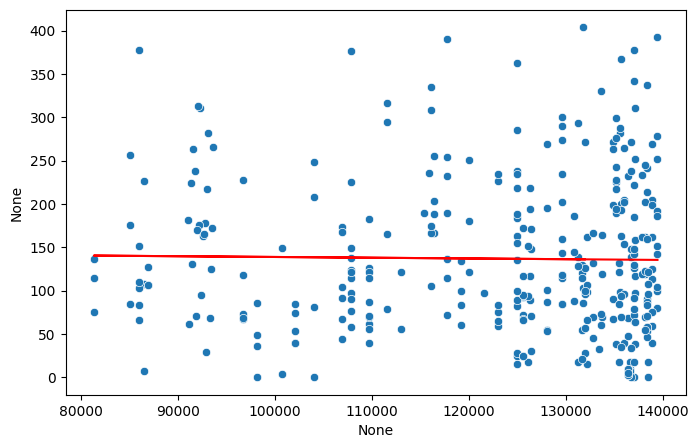

MSE Loss on y: 7939.8408203125


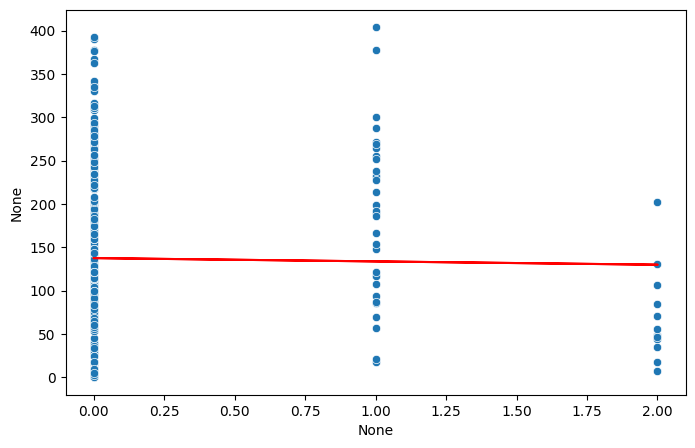

MSE Loss on y: 7938.6953125


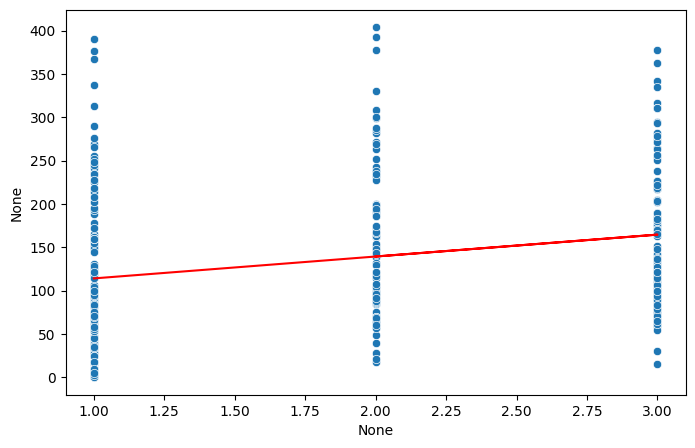

MSE Loss on y: 7478.78173828125


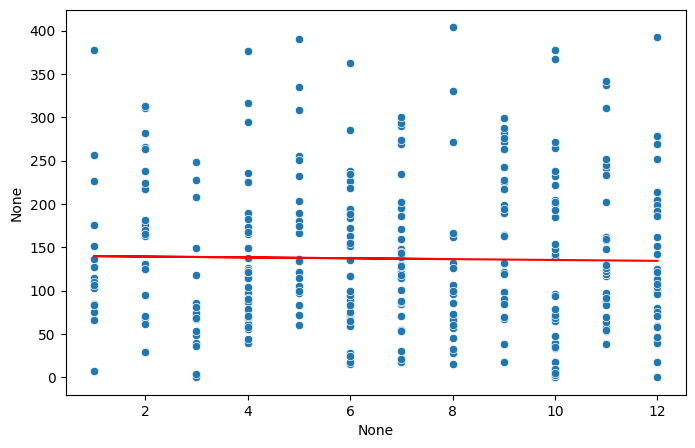

MSE Loss on y: 7939.232421875


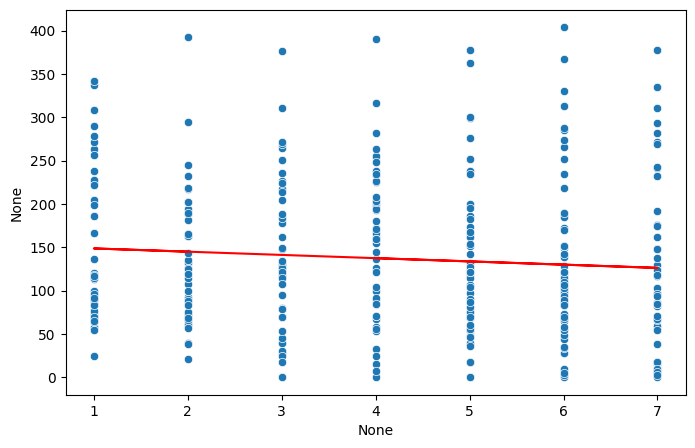

MSE Loss on y: 7885.8828125


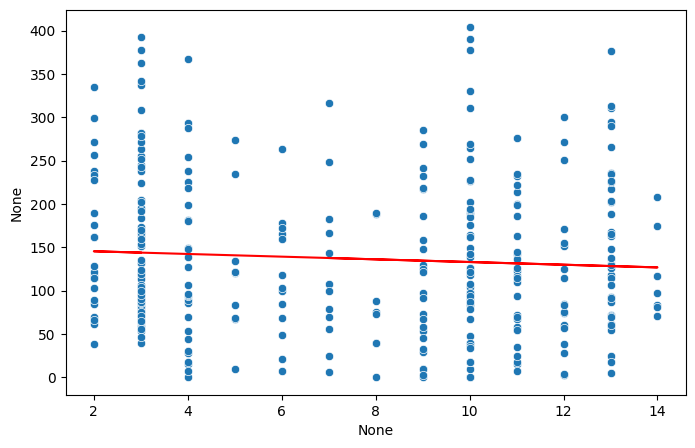

MSE Loss on y: 7904.43896484375


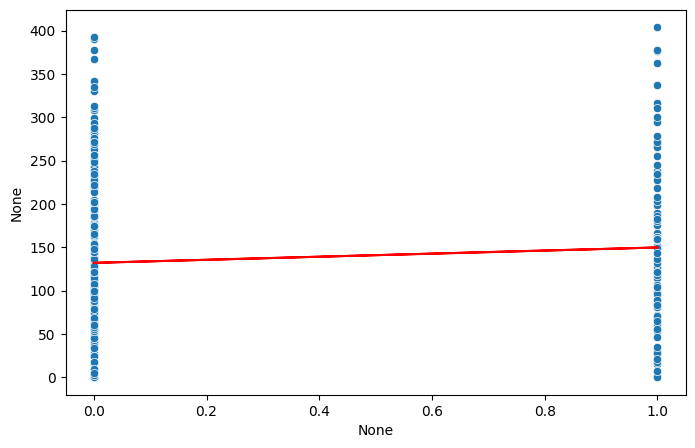

MSE Loss on y: 7878.98095703125


In [ ]:
for i in range(0, X_train_tensor.shape[1]):
  show_best_line_fit_parameter(X_train_tensor, y_train_tensor, slope_intercept_parameters[i][0], slope_intercept_parameters[i][1], i)

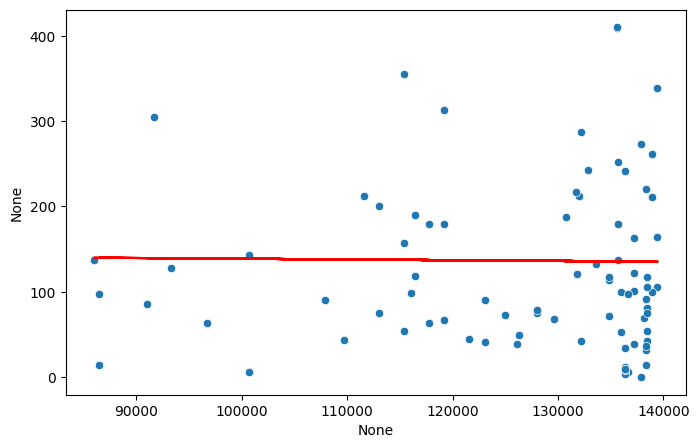

MSE Loss on y: 9376.5263671875


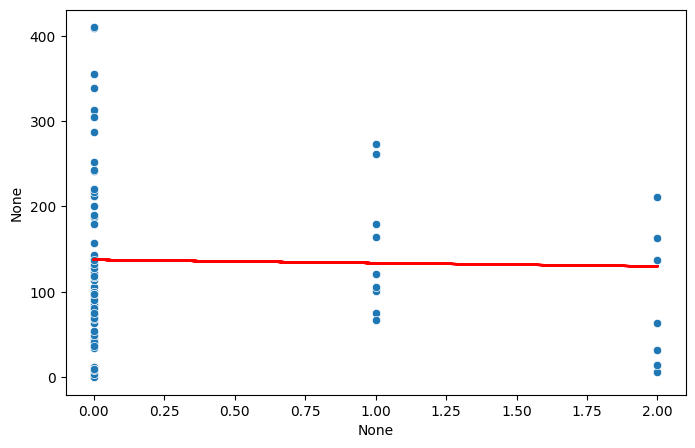

MSE Loss on y: 9334.880859375


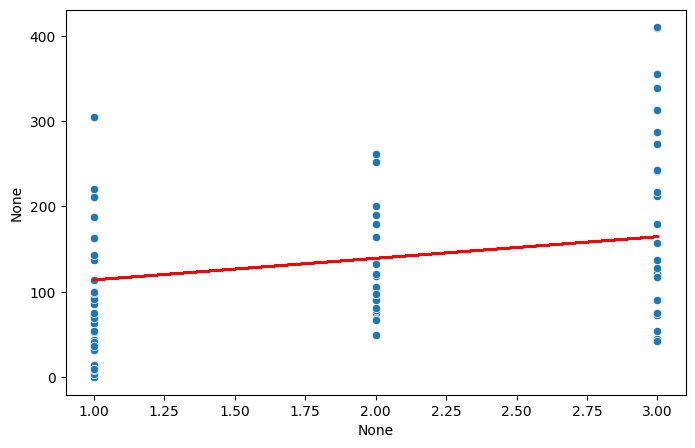

MSE Loss on y: 7720.1630859375


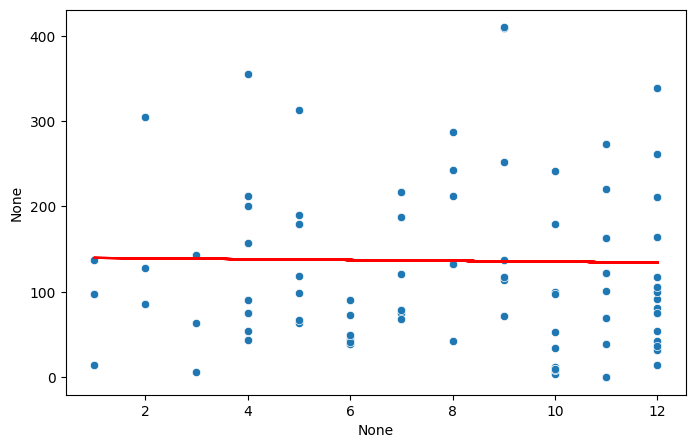

MSE Loss on y: 9356.671875


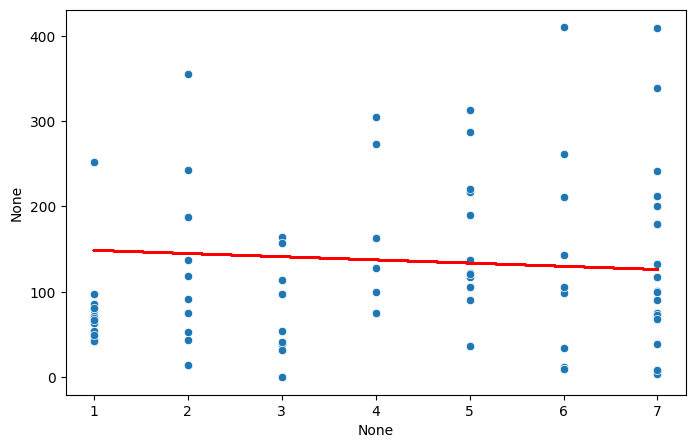

MSE Loss on y: 9787.02734375


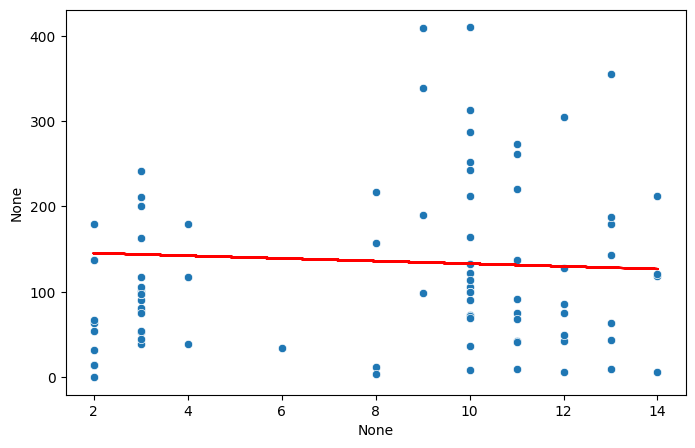

MSE Loss on y: 9622.6318359375


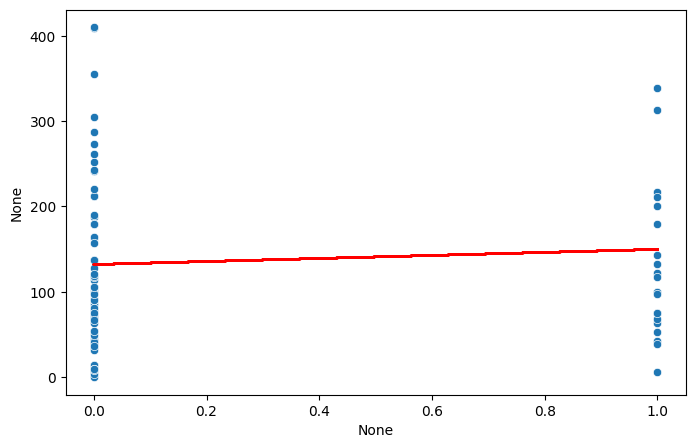

MSE Loss on y: 9383.1357421875


In [ ]:
for i in range(0, X_test_tensor.shape[1]):
  show_best_line_fit_parameter(X_test_tensor, y_test_tensor, slope_intercept_parameters[i][0], slope_intercept_parameters[i][1], i)

> Since they all perform around the same, I will choose the linear model based on the only continuous feature which is page_total_likes, and I note that this corresponds to idx 0 in X_train

In [ ]:
final_idx = 0
final_slope, final_intercept = slope_intercept_parameters[final_idx][0], slope_intercept_parameters[final_idx][1]
print("Note that in this output, the coefficients are rounded to 4 decimal places")
print(f"Equation: y={final_slope:.4f}*x+{final_intercept:.4f}")
print(f"Or in variable terms, \ntotal_interactions = {final_slope:.4f}*page_total_likes+{final_intercept:.4f}")
train_mse_loss = loss_function(y_train_tensor, final_slope * X_train_tensor[:, final_idx] + final_intercept)
print(f"Training MSE loss: {train_mse_loss}")
test_mse_loss = loss_function(y_test_tensor, final_slope * X_test_tensor[:, final_idx] + final_intercept)
print(f"Test MSE loss: {test_mse_loss}")

Note that in this output, the coefficients are rounded to 4 decimal places
Equation: y=-0.0001*x+147.3938
Or in variable terms, 
total_interactions = -0.0001*page_total_likes+147.3938
Training MSE loss: 7939.8408203125
Test MSE loss: 9376.5263671875


In [ ]:
# Mean and std for X_train_normalized
print(f"Mean of X_train_normalized: {X_train_normalized.mean()}")
print(f"Std of X_train_normalized: {X_train_normalized.std()}")
print(f"Mean of X_test_normalized: {X_test_normalized.mean()}")
print(f"Std of X_test_normalized: {X_test_normalized.std()}")

Mean of X_train_normalized: page_total_likes   -3.982393e-16
type               -3.143994e-17
category           -1.257598e-16
post_month         -1.205198e-16
post_weekday        2.266296e-16
post_hour           9.955982e-17
paid                2.619995e-17
dtype: float64
Std of X_train_normalized: page_total_likes    1.0
type                1.0
category            1.0
post_month          1.0
post_weekday        1.0
post_hour           1.0
paid                1.0
dtype: float64
Mean of X_test_normalized: page_total_likes    0.247850
type                0.270303
category           -0.092789
post_month          0.306268
post_weekday        0.054124
post_hour           0.147771
paid               -0.061045
dtype: float64
Std of X_test_normalized: page_total_likes    0.890319
type                1.357992
category            0.994004
post_month          1.022312
post_weekday        1.132902
post_hour           1.033823
paid                0.970956
dtype: float64


In [ ]:
# mean and std of y_train_normalized and y_test_normalized
print(f"Mean of y_train_normalized: {y_train_normalized.mean()}")
print(f"Std of y_train_normalized: {y_train_normalized.std()}")
print(f"Mean of y_test_normalized: {y_test_normalized.mean()}")
print(f"Std of y_test_normalized: {y_test_normalized.std()}")

Mean of y_train_normalized: 1.7029969699264938e-17
Std of y_train_normalized: 0.9999999999999994
Mean of y_test_normalized: -0.154586561043336
Std of y_test_normalized: 1.0806263536030112


In [ ]:
linear_y_test_pred_tensor = final_slope * X_test_tensor[:, final_idx] + final_intercept

> Nice observation! The normalization trained on X_train does not accurately normalize X_test, and likewise with y_train and y_test

### Problem 2b

In [ ]:
def find_coefficients(X_train_tensor_normalized, y_train_tensor_normalized, lr):
  '''
  X_train_tensor_normalized and y_train_tensor_normalized are the normalized tensors here

  That we use to find the coefficients with respect to the normalized input data
  To denormalize later
  '''
  X_train_tensor_normalized_1s = X_train_tensor_normalized.clone().detach()
  X_train_tensor_normalized_1s = torch.cat((torch.ones(X_train_tensor_normalized.shape[0], 1), X_train_tensor_normalized), dim=1)
  X_train_tensor_normalized_1s.requires_grad_(True)
  # add an extra column of 1s to compute the intercept

  coefficients_tensor = torch.ones(X_train_tensor_normalized_1s.shape[1], requires_grad=True)
  num_epochs = 300;
  for epoch in range(num_epochs):
    y_pred_train_tensor_normalized = torch.matmul(X_train_tensor_normalized_1s, coefficients_tensor)
    loss = loss_function(y_train_tensor_normalized, y_pred_train_tensor_normalized)
    loss.backward()
    # coefficients_tensor.grad is not none here
    # if (epoch == num_epochs-1):
      # print(f"Gradient of normalized coefficients tensor after final epoch before zero-ing: {coefficients_tensor.grad}\n")
      # These 2 lines give an idea of the scale of the gradient at the end
    with torch.no_grad():
      coefficients_tensor -= coefficients_tensor.grad*lr
      coefficients_tensor.grad.zero_()

  return coefficients_tensor

In [ ]:
def denormalized_coefficients(X_train_tensor, y_train_tensor, normalized_coefficients_tensor):
    # coefficients_tensor represents the coefficients from find_coefficients
    normalized_coefficients_numpy = normalized_coefficients_tensor.detach().clone().numpy()
    # Convert X_train_tensor to NumPy for calculations
    X_train_numpy = X_train_tensor.detach().clone().numpy()
    denormalized_coefficients_numpy = np.zeros(normalized_coefficients_numpy.shape)
    y_train_tensor_std = y_train_tensor.std().item()
    y_train_tensor_mean = y_train_tensor.mean().item()

    for i in range(X_train_tensor.shape[1]):
        feature_std = np.std(X_train_numpy[:, i])
        denormalized_coefficients_numpy[i] = normalized_coefficients_numpy[i] * y_train_tensor_std / feature_std

    # Calculate the constant term (last element in denormalized_coefficients_numpy)

    denormalized_coefficients_numpy[-1] = y_train_tensor_mean + y_train_tensor_std * (normalized_coefficients_numpy[-1] - np.sum(normalized_coefficients_numpy[:-1] * X_train_numpy.mean(axis=0)/X_train_numpy.std(axis=0)))

    # Convert back to PyTorch tensor with requires_grad=True if needed
    denormalized_coefficients = torch.tensor(denormalized_coefficients_numpy, dtype=torch.float32, requires_grad=True)

    return denormalized_coefficients

In [ ]:
coefficients_tensor_train = find_coefficients(X_train_tensor_normalized, y_train_tensor_normalized, 0.1)
print(f"Normalized coefficients tensor: {coefficients_tensor_train}")
coefficients_tensor_train.data = denormalized_coefficients(X_train_tensor, y_train_tensor, coefficients_tensor_train).requires_grad_(True)
print(f"\nActual coefficients_tensor trained on training data: {coefficients_tensor_train}")

Normalized coefficients tensor: tensor([-4.9860e-09, -4.0854e-02,  1.3998e-03,  2.4364e-01,  7.1949e-02,
        -5.4437e-02, -3.1485e-02,  9.6384e-02], requires_grad=True)

Actual coefficients_tensor trained on training data: tensor([-2.6926e-11, -7.8350e+00,  1.4672e-01,  6.6479e+00,  3.2115e+00,
        -1.2314e+00, -6.2980e+00,  9.8316e+01], requires_grad=True)


In [ ]:
# Print equation in word form
print(f"Actual equation rounded to 4 decimal places: \ny_pred = {round(coefficients_tensor_train[0].item(), 4)}*page_total_likes + {round(coefficients_tensor_train[1].item(), 4)}*type + {round(coefficients_tensor_train[2].item(), 4)}*category + \n{round(coefficients_tensor_train[3].item(), 4)}*post_month + {round(coefficients_tensor_train[4].item(), 4)}*post_weekday + {round(coefficients_tensor_train[5].item(), 4)}*post_hour + {round(coefficients_tensor_train[6].item(), 4)}*paid + {round(coefficients_tensor_train[7].item(), 4)}")

Actual equation rounded to 4 decimal places: 
y_pred = -0.0*page_total_likes + -7.835*type + 0.1467*category + 
6.6479*post_month + 3.2115*post_weekday + -1.2314*post_hour + -6.298*paid + 98.3161


In [ ]:
coefficients_tensor_test = find_coefficients(X_test_tensor_normalized, y_test_tensor_normalized, 0.1)
print(f"Normalized coefficients tensor: {coefficients_tensor_test}")
coefficients_tensor_test.data = denormalized_coefficients(X_test_tensor, y_test_tensor, coefficients_tensor_test).requires_grad_(True)
print(f"\nActual coefficients_tensor trained on test data: {coefficients_tensor_test}")

Normalized coefficients tensor: tensor([-0.1580,  0.1592,  0.0896,  0.5683, -0.1619,  0.1176,  0.2395, -0.0050],
       requires_grad=True)

Actual coefficients_tensor trained on test data: tensor([-1.0402e-03,  2.4402e+01,  1.0252e+01,  1.6463e+01, -6.9242e+00,
         2.7927e+00,  5.3549e+01,  9.2243e+01], requires_grad=True)


> So some significant difference in our training and testing sets data

In [ ]:
multilinear_y_train_pred_tensor = torch.matmul(X_train_tensor, coefficients_tensor_train[:-1]) + coefficients_tensor_train[-1]
multilinear_train_mse_loss = loss_function(y_train_tensor, multilinear_y_train_pred_tensor)
print(f"Multilinear training MSE loss: {multilinear_train_mse_loss}")

multilinear_y_test_pred_tensor = torch.matmul(X_test_tensor, coefficients_tensor_train[:-1]) + coefficients_tensor_train[-1]
multilinear_test_mse_loss = loss_function(y_test_tensor, multilinear_y_test_pred_tensor)
print(f"Multilinear testing MSE loss: {multilinear_test_mse_loss}")

Multilinear training MSE loss: 8707.896484375
Multilinear testing MSE loss: 10609.765625


In [ ]:
linear_slope, linear_intercept = slope_intercept_parameters[final_idx][0], slope_intercept_parameters[final_idx][1]
linear_y_train_pred_tensor = linear_slope * X_train_tensor[:, final_idx] + linear_intercept
linear_train_mse_loss = loss_function(y_train_tensor, linear_y_train_pred_tensor)
print(f"Linear training MSE loss: {linear_train_mse_loss}")
linear_y_test_pred_tensor = linear_slope * X_test_tensor[:, final_idx] + linear_intercept
linear_test_mse_loss = loss_function(y_test_tensor, linear_y_test_pred_tensor)
print(f"Linear testing MSE loss: {linear_test_mse_loss}")

Linear training MSE loss: 7939.8408203125
Linear testing MSE loss: 9376.5263671875


> For this part (problem 2b), I made y_pred based on a sum of (weight * feature for all features) and a constant tensor. I used all features since I knew the computer could still do the computations extremely quickly.

> I then used a similar gradient descent algorithm as for part 2a to get optimal values for these coefficients

> The MSE is very similar for the training and test set, and this is likely due to removing outliers so that neither of the sets is massively imbalanced by outliers

> It seems that the linear model's training and testing MSE losses are somewhat lower than that of the multilinear model. Maybe this is because the categorical features don't really have a pattern in their distributions and thus we increase the model's complexity

> And the normalization scaled on y_train is close but does not completely normalize y_test

In [ ]:
print(y_train.std())
print(y_train.mean())
print(y_train_normalized.std())
print(y_train_normalized.mean())

89.2488215583393
136.86725663716814
0.9999999999999994
1.7029969699264938e-17


In [ ]:
print(y_test.std())
print(y_test.mean())
print(y_test_normalized.std())
print(y_test_normalized.mean())

96.44462860395403
123.07058823529412
1.0806263536030112
-0.154586561043336


> Ooh, this might not be good! The normalization transformation from X_train does not properly normalize X_test

### Problem 2c

> Note from my EDA above that 1: category==1 seems to have a significantly lower mean than category==2 and 3, but around the same std and 2: paid==1.0 seems to have a tad bit higher mean and around the same std as paid==0.0

> I could consider differences in other features, but I see that 'category' and 'paid' are the only features to have a large enough number of samples for each feature value for me to try and generalize to the whole dataset


> In all, I will make my function y_nonlinear_pred = (p1 x category + p2) x (p3 times paid + p4) for parameters p1 through p4

> Because my z-score normalization works well for varying means and standard deviations, I will train on X_train_normalized on y_train_normalized

In [ ]:
category_column_index_train = X_train.columns.get_loc('category')  # Get index using Pandas DataFrame
category_column_tensor_train_normalized = torch.tensor(X_train_normalized.iloc[:, category_column_index_train].values, dtype=torch.float32).unsqueeze(1)
category_column_tensor_train = torch.tensor(X_train.iloc[:, category_column_index_train].values, dtype=torch.float32).unsqueeze(1)
# Added unsqueeze(1) to make it a 2D tensor with one column

paid_column_index_train = X_train.columns.get_loc('paid')  # Get index using Pandas DataFrame
paid_column_tensor_train_normalized = torch.tensor(X_train_normalized.iloc[:, paid_column_index_train].values, dtype=torch.float32).unsqueeze(1)
paid_column_tensor_train = torch.tensor(X_train.iloc[:, paid_column_index_train].values, dtype=torch.float32).unsqueeze(1)
# Added unsqueeze(1) to make it a 2D tensor with one column

In [ ]:
category_column_index_test = X_test.columns.get_loc('category')  # Get index using Pandas DataFrame
category_column_tensor_test_normalized = torch.tensor(X_test_normalized.iloc[:, category_column_index_test].values, dtype=torch.float32).unsqueeze(1)
category_column_tensor_test = torch.tensor(X_test.iloc[:, category_column_index_test].values, dtype=torch.float32).unsqueeze(1)
# Added unsqueeze(1) to make it a 2D tensor with one

paid_column_index_test = X_test.columns.get_loc('paid')  # Get index using Pandas DataFrame
paid_column_tensor_test_normalized = torch.tensor(X_test_normalized.iloc[:, paid_column_index_test].values, dtype=torch.float32).unsqueeze(1)
paid_column_tensor_test = torch.tensor(X_test.iloc[:, paid_column_index_test].values, dtype=torch.float32).unsqueeze(1)


In [ ]:
print(y_train_tensor_normalized.shape)
print(category_column_tensor_train_normalized.shape)

torch.Size([339])
torch.Size([339, 1])


In [ ]:
def find_nonlinear_coefficients(category_column_tensor_normalized, paid_column_tensor_normalized, y_train_tensor_normalized):
  """
  Take in the normalized tensors to find the coefficients with respect to the normalized input data
  And denormalize those coefficients later
  """
  nonlinear_parameters_tensor_normalized = torch.ones(4, requires_grad=True) # initialize parameters with requires_grad=True
  num_epochs = 300
  lr = 0.1 # define learning rate

  for epoch in range(num_epochs):
    p1, p2, p3, p4 = nonlinear_parameters_tensor_normalized # unpack parameters

    # Ensure y_pred_train_normalized_tensor has the correct shape for loss calculation
    # Updated to use correct indexing for 2D tensors
    y_pred_train_tensor_normalized = (p1 * category_column_tensor_normalized + p2) * (p3 * paid_column_tensor_normalized + p4)

    loss = loss_function(y_train_tensor_normalized, y_pred_train_tensor_normalized)
    loss.backward()

    # if (epoch == num_epochs-1):
      # print(f"Gradient of normalized nonlinear coefficients tensor after final epoch before zero-ing: \n{nonlinear_parameters_tensor_normalized.grad}\n")
      # These 2 lines give an idea of the scale of the gradient at the end
    with torch.no_grad():
      nonlinear_parameters_tensor_normalized -= nonlinear_parameters_tensor_normalized.grad * lr
      nonlinear_parameters_tensor_normalized.grad.zero_()
  return nonlinear_parameters_tensor_normalized

In [ ]:
def denormalized_nonlinear_coefficients(X_train_tensor, y_train_tensor, category_column_tensor_train, paid_column_tensor_train, nonlinear_coefficients_tensor_normalized):
  # Unpack normalized coefficients
  p1, p2, p3, p4 = nonlinear_coefficients_tensor_normalized.detach().clone()

  # Get standard deviations of original features
  category_std = category_column_tensor_train.std().item()
  paid_std = paid_column_tensor_train.std().item()

  # Get means of original features
  category_mean = category_column_tensor_train.mean().item()
  paid_mean = paid_column_tensor_train.mean().item()

  # Get standard deviation and mean of target variable
  y_train_tensor_std = y_train_tensor.std().item()
  y_train_tensor_mean = y_train_tensor.mean().item()

  # Denormalize coefficients
  p1_denorm = p1 * category_std
  p2_denorm = p2 * y_train_tensor_std + p1 * category_mean * y_train_tensor_std / category_std
  p3_denorm = p3 * paid_std
  p4_denorm = p4 * y_train_tensor_std + p3 * paid_mean * y_train_tensor_std / paid_std

  return [p1_denorm, p2_denorm, p3_denorm, p4_denorm]

In [ ]:
nonlinear_coefficients_tensor_normalized = find_nonlinear_coefficients(category_column_tensor_train_normalized, paid_column_tensor_train_normalized, y_train_tensor_normalized)
print(f"Normalized nonlinear coefficients tensor: \n{nonlinear_coefficients_tensor_normalized}")

Normalized nonlinear coefficients tensor: 
tensor([0.0601, 0.0705, 0.0664, 0.0624], requires_grad=True)


In [ ]:
# def denormalized_coefficients(X_train_tensor, y_train_tensor, normalized_coefficients_tensor):
# nonlinear_coefficients_tensor = denormalized_coefficients(category_column_tensor_train, paid_column_tensor_train, nonlinear_coefficients_tensor_normalized)
nonlinear_coefficients_tensor = denormalized_nonlinear_coefficients(X_train_tensor, y_train_tensor, category_column_tensor_train, paid_column_tensor_train, nonlinear_coefficients_tensor_normalized)
print(f"Actual nonlinear coefficients tensor: \n{nonlinear_coefficients_tensor}")

Actual nonlinear coefficients tensor: 
[tensor(0.0513), tensor(18.2641), tensor(0.0297), tensor(9.2119)]


In [ ]:
print(f"Equation in word form rounded to 4 decimal places: \ny_pred = ( {round(nonlinear_coefficients_tensor[0].item(), 4)}*category + {round(nonlinear_coefficients_tensor[1].item(), 4)} ) * ( {round(nonlinear_coefficients_tensor[2].item(), 4)}*paid + {round(nonlinear_coefficients_tensor[3].item(), 4)} )")

Equation in word form rounded to 4 decimal places: 
y_pred = ( 0.0513*category + 18.2641 ) * ( 0.0297*paid + 9.2119 )


In [ ]:
nonlinear_y_pred_train_tensor = (nonlinear_coefficients_tensor[0] * category_column_tensor_train + nonlinear_coefficients_tensor[1]) * (nonlinear_coefficients_tensor[2] * paid_column_tensor_train + nonlinear_coefficients_tensor[3])
print(f"MSE loss on training set: {loss_function(y_train_tensor, nonlinear_y_pred_train_tensor)}")

MSE loss on training set: 8993.6416015625


In [ ]:
nonlinear_y_pred_test_tensor = (nonlinear_coefficients_tensor[0] * category_column_tensor_test + nonlinear_coefficients_tensor[1]) * (nonlinear_coefficients_tensor[2] * paid_column_tensor_test + nonlinear_coefficients_tensor[3])
print(f"MSE loss on testing set: {loss_function(y_test_tensor, nonlinear_y_pred_test_tensor)}")

MSE loss on testing set: 11324.2373046875


In [ ]:
print(nonlinear_y_pred_test_tensor)

tensor([[168.7194],
        [168.7194],
        [169.2630],
        [170.2106],
        [169.6640],
        [169.1917],
        [169.6640],
        [169.2630],
        [169.2630],
        [169.7368],
        [168.7194],
        [168.7194],
        [168.7194],
        [169.1917],
        [168.7194],
        [168.7194],
        [168.7194],
        [169.6640],
        [169.1917],
        [169.1917],
        [168.7194],
        [169.2630],
        [169.1917],
        [169.7368],
        [170.2106],
        [168.7194],
        [168.7194],
        [169.6640],
        [168.7194],
        [168.7194],
        [168.7194],
        [169.2630],
        [169.1917],
        [169.2630],
        [168.7194],
        [170.2106],
        [169.6640],
        [169.7368],
        [168.7194],
        [168.7194],
        [168.7194],
        [169.7368],
        [168.7194],
        [169.6640],
        [169.6640],
        [169.1917],
        [169.6640],
        [168.7194],
        [169.6640],
        [169.1917],


> This is probably very low due to the scale of 'category' and 'paid' being extremely low and only taking a few discrete values in the same range. As such, I will now try with multiplying by a linear term of page_total_likes

### Boxplots for each model / quantile

> I will create groups of samples each containing the top fifth, the second-top fifth, and so on in terms of 'total_interactions' values

> I will group from the test set only to prevent data leakage

In [ ]:
# Create a subset of df containing only the testing data
df_test = df[df.index.isin(y_test.index)].copy()

# Calculate quantiles on the testing data subset
df_test.loc[:, 'quantile_labels'] = pd.qcut(df_test['total_interactions'], 5, labels=False, duplicates='drop') + 1

# Get indices (from the full df) for each quantile within the testing data subset
quantile_indices_test = {
    i: df_test.index[df_test['quantile_labels'] == i].tolist()
    for i in range(1, 6)
}

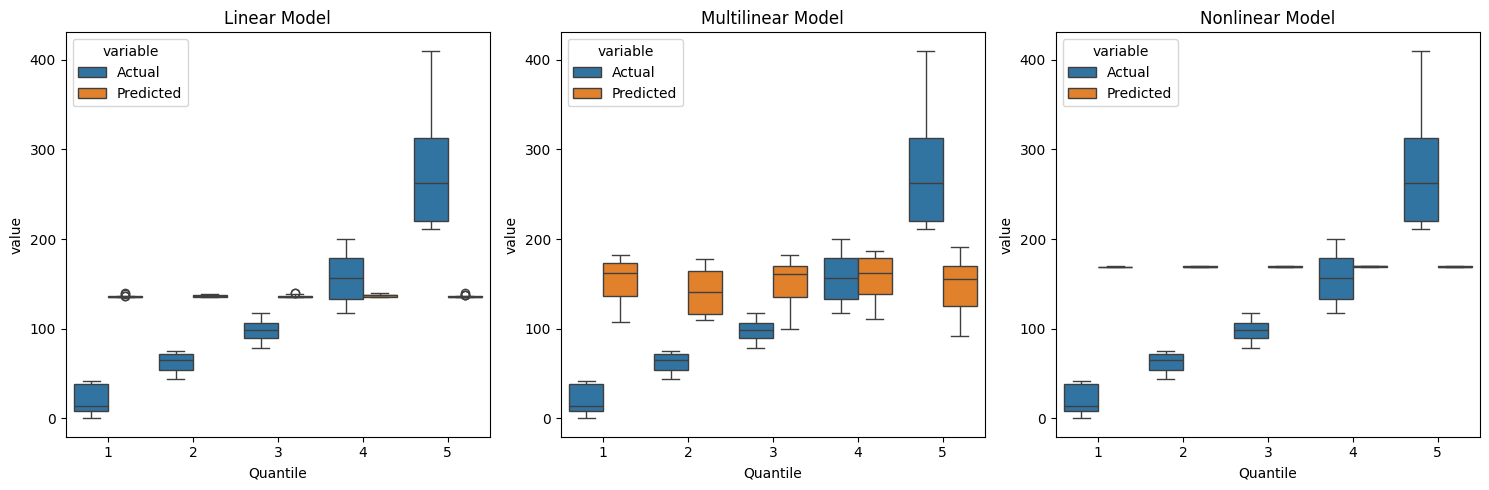

In [ ]:
# Create DataFrames for plotting
df_linear_plot = pd.DataFrame({'Actual': y_test,
                               'Predicted': linear_y_test_pred_tensor.detach().numpy().flatten(),
                               'Quantile': df_test['quantile_labels']},
                              index=y_test.index)  # Use y_test.index for alignment

df_multilinear_plot = pd.DataFrame({'Actual': y_test, 'Predicted': multilinear_y_test_pred_tensor.detach().numpy(), 'Quantile': df_test['quantile_labels']})

# Reshape nonlinear_y_pred_test_tensor to be 1-dimensional
nonlinear_y_pred_test_1d = nonlinear_y_pred_test_tensor.detach().numpy().flatten()

# Create DataFrame for nonlinear model
df_nonlinear_plot = pd.DataFrame({'Actual': y_test, 'Predicted': nonlinear_y_pred_test_1d, 'Quantile': df_test['quantile_labels']}) # Using y_test and df_test directly

# Create boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

sns.boxplot(x='Quantile', y='value', hue='variable', data=pd.melt(df_linear_plot, id_vars=['Quantile'], value_vars=['Actual', 'Predicted']), ax=axes[0])
axes[0].set_title('Linear Model')

sns.boxplot(x='Quantile', y='value', hue='variable', data=pd.melt(df_multilinear_plot, id_vars=['Quantile'], value_vars=['Actual', 'Predicted']), ax=axes[1])
axes[1].set_title('Multilinear Model')

sns.boxplot(x='Quantile', y='value', hue='variable', data=pd.melt(df_nonlinear_plot, id_vars=['Quantile'], value_vars=['Actual', 'Predicted']), ax=axes[2])
axes[2].set_title('Nonlinear Model')

plt.tight_layout()
plt.show()

In [ ]:
print(df_linear_plot)

     Actual   Predicted  Quantile
76        0  135.551590         1
474      86  139.577988         3
115       6  135.659027         1
83      122  135.613083         4
453     128  139.385010         4
..      ...         ...       ...
162     410  135.747055         5
225     121  136.074173         4
42       36  135.512085         1
113      97  135.659027         3
157     137  135.739929         4

[85 rows x 3 columns]


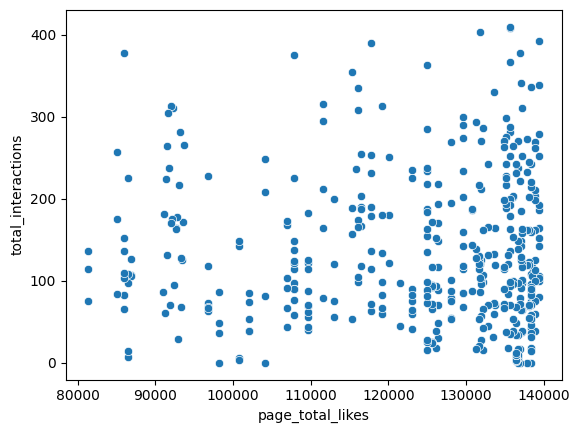

In [ ]:
# Plot page_total_likes vs total_interactions
sns.scatterplot(x='page_total_likes', y='total_interactions', data=df)
plt.show()

In [ ]:
print(df_multilinear_plot)

     Actual   Predicted  Quantile
1       164  178.761230         4
7       339  100.192741         5
11      106  166.346817         3
16       54  169.328064         2
18       75  110.120682         2
..      ...         ...       ...
468     305  165.541779         5
474      86  136.127029         3
483      97  181.980499         3
485      14  158.307617         1
492     137  162.547394         4

[85 rows x 3 columns]


In [ ]:
print(df_nonlinear_plot)

     Actual   Predicted  Quantile
1       164  168.719437         4
7       339  168.719437         5
11      106  169.262955         3
16       54  170.210602         2
18       75  169.664047         2
..      ...         ...       ...
468     305  169.664047         5
474      86  169.191727         3
483      97  168.719437         3
485      14  169.736771         1
492     137  169.664047         4

[85 rows x 3 columns]


> Here, df_linear_plot and df_nonlinear_plot probably didn't show the predicted values due to their predictions being so close together that the std was too small

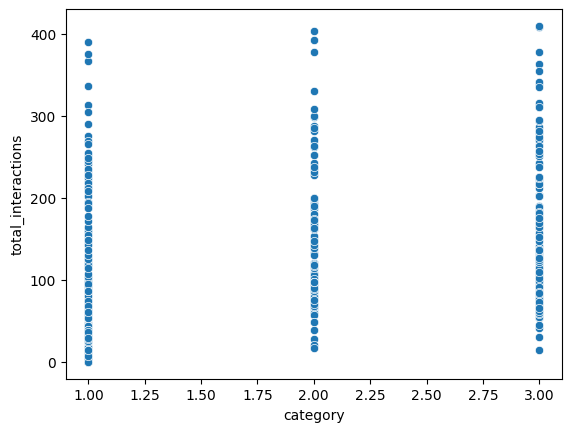

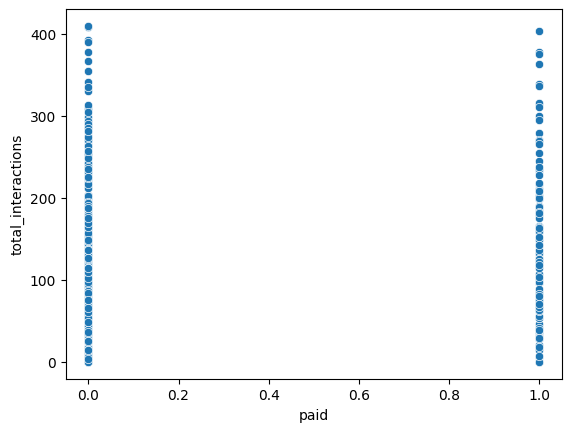

In [ ]:
# scatter category value versus total_interactions
sns.scatterplot(x='category', y='total_interactions', data=df)
plt.show()
sns.scatterplot(x='paid', y='total_interactions', data=df)
plt.show()

> I think the nonlinear model had slightly higher loss due to the chosen features of 'paid' and 'category' only taking very few discrete values in a very small range. Also, the 'category' and 'paid' values are so small numerically and that is why I think the predictions for the nonlinear model are so close to each other

> I think the linear model did not work so well because the data was not linear but rather clustered with respect to page_total_likes. Also, it only factored in a small slope times page_total_likes and that might be why the predictions are so close together (not necessarily to the true values) for each quantile

> I think the multilinear model worked slightly better because I made it take into account all features. However, not much better than the linear model due to the non-clear increasing/decreasing trend with respect to each of the categorical, low numerical-valued features

# Problem 3 (Thresholded accuracies)

In [ ]:
def threshold_accuracy(y_true, y_pred, T):
  """
  Computes the thresholded accuracy of a model
  IE the accuracy with respect to predictions being within T standard deviations
  of the actual value
  """
  diff = torch.abs(y_true - y_pred)
  num_correct_predictions = 0
  std_true = torch.std(y_true)
  for i in range(len(y_pred)):
    if (y_pred[i] < y_true[i] - T*std_true) or (y_pred[i] > y_true[i] + T*std_true):
      num_correct_predictions += 0
    else:
      num_correct_predictions += 1

  total_predictions = len(y_true)
  accuracy = num_correct_predictions / total_predictions
  return accuracy

In [ ]:
thresholds = [0.25, 0.5, 1]

# Linear Model thresholded accuracies
linear_accuracies = [threshold_accuracy(y_test_tensor, linear_y_test_pred_tensor, T) for T in thresholds]

# Multilinear Model thresholded accuracies
multilinear_accuracies = [threshold_accuracy(y_test_tensor, multilinear_y_test_pred_tensor, T) for T in thresholds]

# Nonlinear Model thresholded accuracies
nonlinear_accuracies = [threshold_accuracy(y_test_tensor, nonlinear_y_pred_test_tensor, T) for T in thresholds]

In [ ]:
print(f"Linear Model thresholded accuracies to 4 decimal places: {linear_accuracies}")
print(f"Multilinear Model thresholded accuracies: {multilinear_accuracies}")
print(f"Nonlinear Model thresholded accuracies: {nonlinear_accuracies}")

Linear Model thresholded accuracies to 4 decimal places: [0.1411764705882353, 0.32941176470588235, 0.6823529411764706]
Multilinear Model thresholded accuracies: [0.10588235294117647, 0.27058823529411763, 0.6588235294117647]
Nonlinear Model thresholded accuracies: [0.09411764705882353, 0.23529411764705882, 0.5411764705882353]


> Here, the nonlinear model performs the best. This is likely because in the nonlinear model, I take in terms that I deem to be very relevant to calculating 'total_interactions' (justified at the top of part 2c in a text box) and I am accounting for interaction between them without too much model complexity.

# Problem 4 (Cross Validation)

In [ ]:
def get_tensors(X_train, X_test, y_train, y_test):
  X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)
  return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

In [ ]:
def linear_model_quick_prediction(X_train, X_test, y_train, y_test):
  X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = get_tensors(X_train, X_test, y_train, y_test)
  X_train_tensor_normalized, X_test_tensor_normalized, y_train_tensor_normalized, y_test_tensor_normalized = z_score_normalize(X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor)
  slope, intercept = find_slope_intercept(X_train_tensor_normalized, y_train_tensor_normalized, final_idx)
  slope, intercept = denormalized_slope_intercept(X_train_tensor, y_train_tensor, slope, intercept, final_idx)
  y_pred_tensor = slope * X_test_tensor[:, final_idx] + intercept
  print(f"Linear MSE Loss on test set: {loss_function(y_test_tensor, y_pred_tensor)}")

In [ ]:
def multilinear_model_quick_prediction(X_train, X_test, y_train, y_test, lr=0.1):
  """
  Quickly predicts y_pred for the multilinear model using normalized features.

  Returns the predicted values for the test set.
  """

  # Normalize features
  X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = z_score_normalize(X_train, X_test, y_train, y_test)

  X_train_tensor_normalized, X_test_tensor_normalized, y_train_tensor_normalized, y_test_tensor_normalized = get_tensors(X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized)

  # Find normalized coefficients
  coefficients_tensor_normalized = find_coefficients(X_train_tensor_normalized, y_train_tensor_normalized, lr)  # Assuming you have this function from Problem 2b

  # Convert to PyTorch tensors (original scale)
  X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = get_tensors(X_train, X_test, y_train, y_test)
  # Denormalize coefficients
  coefficients_tensor = denormalized_coefficients(X_train_tensor, y_train_tensor, coefficients_tensor_normalized)  # Assuming you have this function from Problem 2b

  # Make predictions
  y_test_pred = torch.matmul(X_test_tensor, coefficients_tensor[:-1]) + coefficients_tensor[-1]

  test_mse_loss = loss_function(y_test_tensor, y_test_pred)
  print(f"Multilinear testing MSE loss: {test_mse_loss}")


In [ ]:
def nonlinear_model_quick_prediction(X_train, X_test, y_train, y_test, lr=0.1):
    """
    Quickly predicts y_pred for the nonlinear model using normalized features.
    """

    X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = get_tensors(X_train, X_test, y_train, y_test)
    # Normalize features
    X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = z_score_normalize(X_train, X_test, y_train, y_test)
    X_train_tensor_normalized, X_test_tensor_normalized, y_train_tensor_normalized, y_test_tensor_normalized = get_tensors(X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized)

    # Extract relevant columns and convert to tensors
    category_column_index_train = X_train.columns.get_loc('category')
    category_column_tensor_train_normalized = torch.tensor(X_train_normalized.iloc[:, category_column_index_train].values, dtype=torch.float32).unsqueeze(1)
    category_column_tensor_train = torch.tensor(X_train.iloc[:, category_column_index_train].values, dtype=torch.float32).unsqueeze(1)

    paid_column_index_train = X_train.columns.get_loc('paid')
    paid_column_tensor_train_normalized = torch.tensor(X_train_normalized.iloc[:, paid_column_index_train].values, dtype=torch.float32).unsqueeze(1)
    paid_column_tensor_train = torch.tensor(X_train.iloc[:, paid_column_index_train].values, dtype=torch.float32).unsqueeze(1)

    category_column_index_test = X_test.columns.get_loc('category')
    category_column_tensor_test = torch.tensor(X_test.iloc[:, category_column_index_test].values, dtype=torch.float32).unsqueeze(1)

    paid_column_index_test = X_test.columns.get_loc('paid')
    paid_column_tensor_test = torch.tensor(X_test.iloc[:, paid_column_index_test].values, dtype=torch.float32).unsqueeze(1)

    nonlinear_coefficients_tensor_normalized = find_nonlinear_coefficients(category_column_tensor_train_normalized, paid_column_tensor_train_normalized, y_train_tensor_normalized)
    nonlinear_coefficients_tensor = denormalized_nonlinear_coefficients(X_train_tensor, y_train_tensor, category_column_tensor_train, paid_column_tensor_train, nonlinear_coefficients_tensor_normalized)
    y_test_pred = (nonlinear_coefficients_tensor[0] * category_column_tensor_test + nonlinear_coefficients_tensor[1]) * (nonlinear_coefficients_tensor[2] * paid_column_tensor_test + nonlinear_coefficients_tensor[3])
    test_mse_loss = loss_function(y_test_tensor, y_test_pred)
    print(f"Nonlinear testing MSE loss: {test_mse_loss}")

In [ ]:
# Define multiple train/test splits with different random seeds
seeds = [45, 21, 2025]

X_trains, X_tests, y_trains, y_tests = [], [], [], []
for seed in seeds:
  X_train, X_test, y_train, y_test = train_test_split(X, y, 0.2, seed)
  X_trains.append(X_train)
  X_tests.append(X_test)
  y_trains.append(y_train)
  y_tests.append(y_test)

# Start with the linear model

count = 0 # number of seeds traversed so far

for seed in seeds:
  X_train, X_test, y_train, y_test = X_trains[count], X_tests[count], y_trains[count], y_tests[count]
  linear_model_quick_prediction(X_train, X_test, y_train, y_test)
  multilinear_model_quick_prediction(X_train, X_test, y_train, y_test)
  nonlinear_model_quick_prediction(X_train, X_test, y_train, y_test)
  print('\n')
  count+=1

Linear MSE Loss on test set: 6819.4130859375
Multilinear testing MSE loss: 8097.4970703125
Nonlinear testing MSE loss: 8611.802734375


Linear MSE Loss on test set: 7791.32373046875
Multilinear testing MSE loss: 10239.150390625
Nonlinear testing MSE loss: 9928.2333984375


Linear MSE Loss on test set: 8143.947265625
Multilinear testing MSE loss: 9286.861328125
Nonlinear testing MSE loss: 9791.3232421875




> The linear model performs significantly better on all 3 splits. This is likely because, as explained before, the multilinear model and nonlinear model are also heavily based on categorical features that only take small values in a small range. The linear model, however, only takes in the continuous feature 'page_total_likes', thus leading to fewer scaling issues from using the categorical features